In [145]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
import xarray as xr
#from utils import u_statistics as u_stat
import pickle as pkl
# from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import glob
from scipy.stats import binned_statistic
from utils import constants as cnst

#pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [144]:
cd ..

/home/ck/pythonWorkspace


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [146]:
# those three are created from storm cut out kernels (storm netcdf files needed!)

OBS3 = pkl.load( open ('/home/ck/DIR/cornkle/data/DYAMOND/UM-5km/MCS/SAm/UM-5k_5000km2_-40_tir_newShear.p', 'rb'))

In [147]:
OBS3.keys()

dict_keys(['hour', 'month', 'year', 'area', 'lon', 'lat', 'clon', 'clat', 'tmin', 'tmean', 'tcw', 'shear', 'ef', 'pmax', 'pmean', 't', 'p'])

In [148]:
np.unique(OBS3['year'])

array([2020])

In [149]:
def create_dic(dic):
    pp = np.array(dic['pmax'])
    pm = np.array(dic['pmean'])
    tt = np.array(dic['tmin'])
    ttm = np.array(dic['tmean'])
    month = np.array(dic['month'])
    area = np.array(dic['area'])
    lat = np.array(dic['clat'])
    lon = np.array(dic['clon'])
    hour = np.array(dic['hour'])
    tcw = np.array(dic['tcw'])
    shear = np.array(dic['shear'])
    ef = np.array(dic['ef'])


    obs_pcp = {
        'prcp' : pp,
        'pmean' : pm,
        'month' : month,
        'area' : (area)*(5**2),
        'tmin' : tt,
        'tmean' : ttm,
        'lat' : lat,
        'lon' : lon,
        'hour' : hour,
        'shear' : shear,
        'tcw'   : tcw,
        'ef'   : ef
    } 
    obs = pd.DataFrame(obs_pcp)
    return obs

In [150]:
obs_gpm = create_dic(OBS3)

In [151]:
np.max(obs_gpm.lat)

-20.203125

In [152]:
obs_gpm.keys()

Index(['prcp', 'pmean', 'month', 'area', 'tmin', 'tmean', 'lat', 'lon', 'hour',
       'shear', 'tcw', 'ef'],
      dtype='object')

In [101]:
np.sum((obs_gpm['hour']<=19) & (obs_gpm['hour']>=13))

403

In [102]:
np.sum((obs_gpm['hour']<=19) & (obs_gpm['hour']>=13)& (obs_gpm['prcp']>=5))

234

In [153]:
obs_gpm = obs_gpm[(obs_gpm['hour']>=13)]

In [154]:
len(obs_gpm)

710

In [155]:

def calc_density(v1,v2):

    xy = np.vstack([v1, v2])

    z = gaussian_kde(xy)(xy)

    return z / (z.max() - z.min())


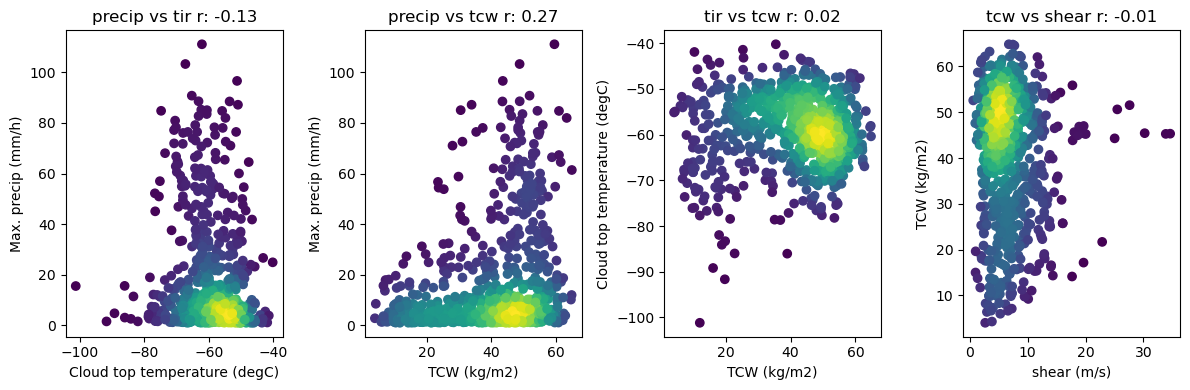

In [156]:

f = plt.figure(figsize=(12,4), dpi=100)
ax = f.add_subplot(141)
cp4s = [obs_gpm.tmin, obs_gpm.prcp] 
r = stats.pearsonr(cp4s[0],cp4s[1])
density = calc_density(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1], c=density)
plt.title('precip vs tir r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('Cloud top temperature (degC)')
plt.ylabel('Max. precip (mm/h)')

ax = f.add_subplot(142)
cp4s = [obs_gpm.tcw, obs_gpm.prcp] 
r = stats.pearsonr(cp4s[0],cp4s[1])
density = calc_density(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1], c=density)
plt.title('precip vs tcw r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('TCW (kg/m2)')
plt.ylabel('Max. precip (mm/h)')

ax = f.add_subplot(143)
# x = obs_gpm.ef[np.isfinite(obs_gpm.ef)]
# y = obs_gpm.prcp[np.isfinite(obs_gpm.ef)]
# cp4s = [x, y]
cp4s = [obs_gpm.tcw, obs_gpm.tmin]
r = stats.pearsonr(cp4s[0],cp4s[1])
density = calc_density(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1], c=density)
plt.title('tir vs tcw r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('TCW (kg/m2)')
plt.ylabel('Cloud top temperature (degC)')
plt.tight_layout()
ax = f.add_subplot(144)
cp4s = [obs_gpm.shear, obs_gpm.tcw]
r = stats.pearsonr(cp4s[0],cp4s[1])
density = calc_density(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1], c=density)
plt.title('tcw vs shear r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('shear (m/s)')
plt.ylabel('TCW (kg/m2)')
plt.tight_layout()
plt.savefig(cnst.network_data + 'figs/DYAMOND/dyamondWINTER_UM-5km_SouthAmerica_scatter.jpg')

In [164]:
p_tcw, bin_edges, binnumber = binned_statistic(obs_gpm.tcw, obs_gpm.prcp, statistic='mean', bins=np.linspace(30,60,15))
tcbins = bin_edges[0:-1] + (bin_edges[1::]-bin_edges[0:-1])/2
pslope, pintercept, pr_value, pp_value, pstd_err = stats.linregress(tcbins, p_tcw)
tir_tcw, bin_edges, binnumber = binned_statistic(obs_gpm.tcw, obs_gpm.tmin, statistic='mean', bins=np.linspace(30,60,15))
tibins = bin_edges[0:-1] + (bin_edges[1::]-bin_edges[0:-1])/2
tslope, tintercept, tr_value, tp_value, tstd_err = stats.linregress(tibins, tir_tcw)

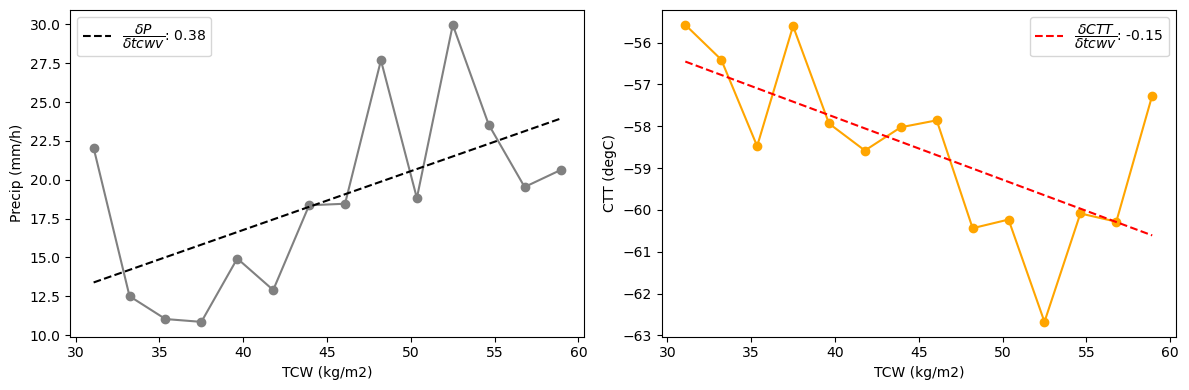

In [165]:
f = plt.figure(figsize=(12,4), dpi=100)
ax = f.add_subplot(121)
plt.plot(tcbins, p_tcw, color='grey', marker='o')
plt.plot(tcbins, pintercept+np.array(tcbins)*pslope, linestyle='dashed', color='k', label=r'$\dfrac{\delta P}{\delta tcwv}$: ' + str(np.round(pslope,2)))
plt.xlabel('TCW (kg/m2)')
plt.ylabel('Precip (mm/h)')
plt.legend()

ax = f.add_subplot(122)
plt.plot(tibins, tir_tcw, color='orange', marker='o')
plt.plot(tibins, tintercept+np.array(tibins)*tslope, linestyle='dashed', color='r', label=r'$\dfrac{\delta CTT}{\delta tcwv}$: ' + str(np.round(tslope,2)))
plt.xlabel('TCW (kg/m2)')
plt.ylabel('CTT (degC)')
plt.legend()
plt.tight_layout()
plt.savefig(cnst.network_data + 'figs/DYAMOND/dyamond_UM-5km_SouthAmerica_averageScaling_TCWbin_unitCorrection_TCW.jpg')

In [167]:
p_tcw, bin_edges, binnumber = binned_statistic(obs_gpm.shear, obs_gpm.prcp, statistic='mean', bins=np.linspace(0,15,15))
tcbins = bin_edges[0:-1] + (bin_edges[1::]-bin_edges[0:-1])/2
pslope, pintercept, pr_value, pp_value, pstd_err = stats.linregress(tcbins, p_tcw)
tir_tcw, bin_edges, binnumber = binned_statistic(obs_gpm.shear, obs_gpm.tmin, statistic='mean', bins=np.linspace(0,15,15))
tibins = bin_edges[0:-1] + (bin_edges[1::]-bin_edges[0:-1])/2
tslope, tintercept, tr_value, tp_value, tstd_err = stats.linregress(tibins, tir_tcw)

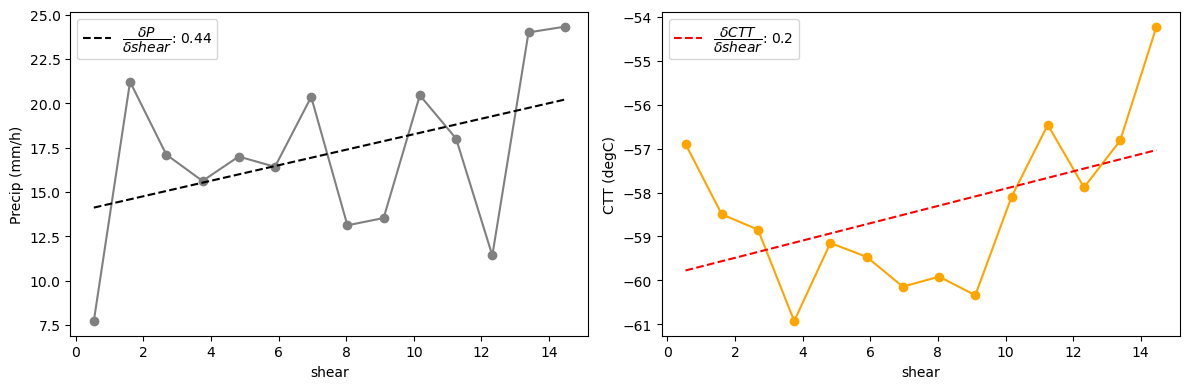

In [168]:
f = plt.figure(figsize=(12,4), dpi=100)
ax = f.add_subplot(121)
plt.plot(tcbins, p_tcw, color='grey', marker='o')
plt.plot(tcbins, pintercept+np.array(tcbins)*pslope, linestyle='dashed', color='k', label=r'$\dfrac{\delta P}{\delta shear}$: ' + str(np.round(pslope,2)))
plt.xlabel('shear')
plt.ylabel('Precip (mm/h)')
plt.legend()

ax = f.add_subplot(122)
plt.plot(tibins, tir_tcw, color='orange', marker='o')
plt.plot(tibins, tintercept+np.array(tibins)*tslope, linestyle='dashed', color='r', label=r'$\dfrac{\delta CTT}{\delta shear}$: ' + str(np.round(tslope,2)))
plt.xlabel('shear')
plt.ylabel('CTT (degC)')
plt.legend()
plt.tight_layout()
plt.savefig(cnst.network_data + 'figs/DYAMOND/dyamond_UM-5km_SouthAmerica_averageScaling_TCWbin_unitCorrection_shear.jpg')